# Exercise 8: Self Supervised Learning

**Summer Semester 2025**

**Author**: Nick Stracke (nick.stracke@lmu.de)

## Instructions

Parts where code should be added are marked using `TODO`. You shouldn't have to edit anything else with the exception of imports.

*Please* add extensive comments to your code to explain what you're doing/trying to do. It is hard to assign partial points for incorrect or incomplete solutions if we do not understand what you are trying to do.

# Task 1: Temperature in Self Supervised Learning

In [6]:
import torch
import matplotlib.pyplot as plt

### Task 1.1: Visualizing the Effect of Temperature

In [7]:
def softmax_temp(logits: torch.Tensor, tau: float = 1.0) -> torch.Tensor:
    """
    Applies the softmax function with temperature.

    Parameters:
        logits (torch.Tensor, shape (N,)): A tensor containing the raw scores or logits.
        tau (float, optional): The temperature parameter to scale the logits. Default is 1.0.

    Returns:
        torch.Tensor: A tensor containing the probabilities after applying the softmax function.
    """
    scaled_logits = logits/tau
    max_logits = torch.max(scaled_logits, dim=-1, keepdim=True).values
    stabilized_logits = scaled_logits - max_logits
    
    exp_logits = torch.exp(stabilized_logits)
    
    sum_exp = torch.sum(exp_logits, dim=-1, keepdim=True)
    softmax = exp_logits / sum_exp
    
    
    return softmax

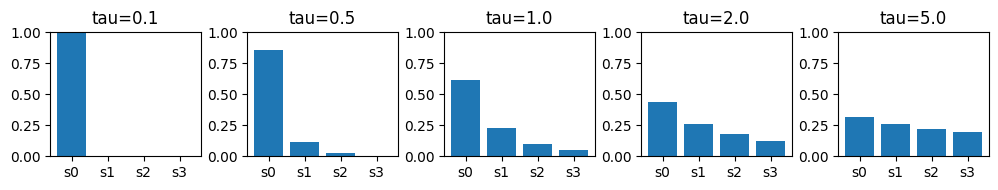

In [8]:
sims = torch.tensor([2.0, 1.0, 0.2, -0.5])
temps = [0.1, 0.5, 1.0, 2.0, 5.0]

fig, ax = plt.subplots(1, len(temps), figsize=(int(2 * len(temps)), 2))
for i, tau in enumerate(temps):
    ax[i].bar(range(len(sims)), softmax_temp(sims, tau).numpy())
    ax[i].set_title(f"tau={tau}")
    ax[i].set_xticks(range(len(sims)))
    ax[i].set_xticklabels([f"s{i}" for i in range(len(sims))])
    ax[i].set_ylim(0, 1)
plt.tight_layout()
plt.show()

### Task 1.2: Intuition: Confidence vs. Uncertainty

##### What happens to the distribution when the temperature is very low (e.g., τ = 0.1)? What does this mean in terms of model confidence?

*it makes the output more confident (peaky)*

##### What happens when τ is very high (e.g., τ = 10.0)? What does this mean for the model’s ability to focus?

*makes the output softer (more uniform) and can lead to nonsense*

### Task 1.3: Why Temperature Matters in Contrastive Learning

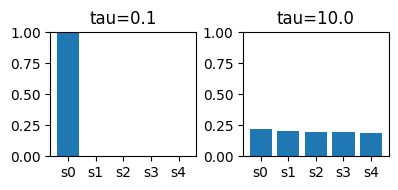

In [9]:
sims = torch.tensor([1.0, 0.2, 0.1, -0.1, -0.3])
temps = [0.1, 10.0]

fig, ax = plt.subplots(1, len(temps), figsize=(int(2 * len(temps)), 2))
for i, tau in enumerate(temps):
    ax[i].bar(range(len(sims)), softmax_temp(sims, tau).numpy())
    ax[i].set_title(f"tau={tau}")
    ax[i].set_xticks(range(len(sims)))
    ax[i].set_xticklabels([f"s{i}" for i in range(len(sims))])
    ax[i].set_ylim(0, 1)
plt.tight_layout()
plt.show()

##### Discuss: Why might a sharper distribution (lower τ ) help the model learn more effectively?

*Because a lower τ makes the model more confident in distinguishing positive (TP) pairs from negative (TN)
 pairs by amplifying the differences in similarity scores.*

# Task 2: SimCLR

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from ex8_2 import SimCLRModel
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision
from tqdm import tqdm
import torch.nn as nn

### Task 2.1: Implement and Train a SimCLR Model
##### Switch to ex2.py to complete the implementation and train the SimCLR model. Come back here once you have a trained checkpoint.

### Task 2.2: Visualize with t-SNE

100%|██████████| 40/40 [00:04<00:00,  8.49it/s]
/Users/ryanqchiqache/.pyenv/versions/myproject-env-py3118/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Running t-SNE...


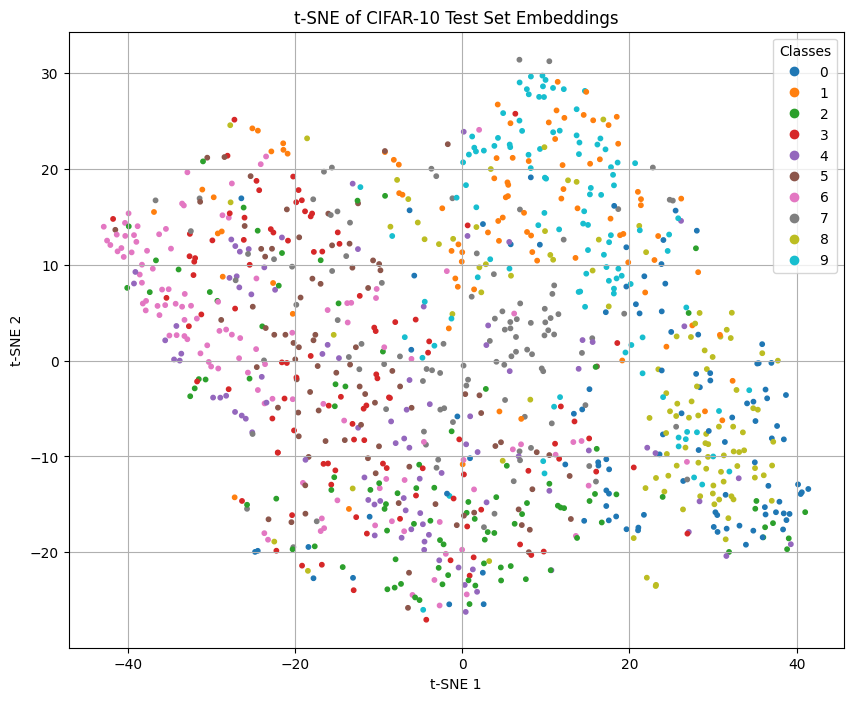

In [11]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
test_batch_size = 256
model = SimCLRModel()
model.load_state_dict(torch.load("simclr_model.pth", map_location="cpu"))
model.eval()
model.to(device)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=T.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, train_labels in tqdm(test_loader):
        imgs = imgs.to(device)
        embedings = model.encoder(imgs)
        all_embeddings.append((embedings.cpu()))
        all_labels.append(train_labels)

all_embeddings = torch.cat(all_embeddings, dim=0).squeeze().numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

subset_embeddings = all_embeddings[:1000]  # Subset for faster t-SNE
subset_labels = all_labels[:1000]

print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
tsne_result = tsne.fit_transform(subset_embeddings)

# --- Plotting ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=subset_labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of CIFAR-10 Test Set Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

### Task 2.3: Quantitative Evaluation using Linear Probing

In [13]:
# CONFIG
num_classes = 10  # CIFAR-10 has 10 classes
train_batch_size = 256
epochs = 50

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=T.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False, num_workers=0)

train_features, train_labels = [], []
with torch.no_grad():
    for x, y in tqdm(train_loader):
        x = x.to(device)
        embedings_en = model.encoder(x)
        train_features.append(embedings_en.cpu())
        train_labels.append(y)


train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

100%|██████████| 196/196 [00:14<00:00, 13.29it/s]


In [14]:
# TODO: define the linear probe, optimizer and classification loss here
probe = torch.nn.Linear(train_features.shape[1], num_classes).to(device)
optimizer = torch.optim.Adam(probe.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
# Train probe
for epoch in range(epochs):
    perm = torch.randperm(train_features.size(0))
    train_features, train_labels = train_features[perm], train_labels[perm]
    total_loss = 0
    for i in range(0, len(train_features), train_batch_size):
        xb = train_features[i:i+train_batch_size].to(device)
        yb = train_labels[i:i+train_batch_size].to(device)
        
        optimizer.zero_grad()
        logits= probe(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * xb.size(0)
        
    axg_loss = total_loss / len(train_features)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {axg_loss:.4f}")

Epoch 1/50 - Loss: 1.6341
Epoch 2/50 - Loss: 1.3409
Epoch 3/50 - Loss: 1.2659
Epoch 4/50 - Loss: 1.2247
Epoch 5/50 - Loss: 1.1957
Epoch 6/50 - Loss: 1.1741
Epoch 7/50 - Loss: 1.1567
Epoch 8/50 - Loss: 1.1418
Epoch 9/50 - Loss: 1.1292
Epoch 10/50 - Loss: 1.1184
Epoch 11/50 - Loss: 1.1089
Epoch 12/50 - Loss: 1.1010
Epoch 13/50 - Loss: 1.0923
Epoch 14/50 - Loss: 1.0847
Epoch 15/50 - Loss: 1.0789
Epoch 16/50 - Loss: 1.0733
Epoch 17/50 - Loss: 1.0683
Epoch 18/50 - Loss: 1.0625
Epoch 19/50 - Loss: 1.0579
Epoch 20/50 - Loss: 1.0531
Epoch 21/50 - Loss: 1.0485
Epoch 22/50 - Loss: 1.0452
Epoch 23/50 - Loss: 1.0405
Epoch 24/50 - Loss: 1.0364
Epoch 25/50 - Loss: 1.0334
Epoch 26/50 - Loss: 1.0295
Epoch 27/50 - Loss: 1.0266
Epoch 28/50 - Loss: 1.0245
Epoch 29/50 - Loss: 1.0208
Epoch 30/50 - Loss: 1.0172
Epoch 31/50 - Loss: 1.0153
Epoch 32/50 - Loss: 1.0130
Epoch 33/50 - Loss: 1.0104
Epoch 34/50 - Loss: 1.0088
Epoch 35/50 - Loss: 1.0055
Epoch 36/50 - Loss: 1.0041
Epoch 37/50 - Loss: 1.0016
Epoch 38/5

In [15]:
test_features = []
test_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        feats = model.encoder(x)
        test_features.append(feats.cpu())
        test_labels.append(y)

test_features = torch.cat(test_features).to(device)
test_labels = torch.cat(test_labels).to(device)

with torch.no_grad():
    logits = probe(test_features)
    preds = logits.argmax(dim=1)
    accuracy = (preds == test_labels).float().mean().item()

print(f"Linear probe test accuracy: {accuracy * 100:.2f}%")


Linear probe test accuracy: 64.93%


# Task 3: CLIP for Zero-Shot Classification

In [16]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import requests

###  Task 3.2: Implement a Zero-Shot Classifier with CLIP

In [31]:
import os
# Load pretrained CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=False) # use fast didnt work since we are working with python not Rust-based tokenizers
model.eval()
image_folder = '/Users/ryanqchiqache/PycharmProjects/Machine-Learning-Learning-Center/ComputerVisionCourse/caption_images'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
images = [Image.open(img_path).convert("RGB") for img_path in image_files]

In [41]:
text_prompts = [
    "a photo of a dog",
    "an image of a cat",
    "a photo of an animal",
    "a photo of a horse",
    "a photo of a car",
    "a picture of a dog",
    "a close-up shot of a cat",
    "a car parked on a street",
    "a domestic cat",
    "a street dog",
    "a vehicle on the road",
    "a horse running in a field",
    "a portrait of a dog",
    "a zoomed-in image of a cat's face",
    "a car in motion",
    "a photo of a furry animal",
    "a car from a side view",
    "an image of a wild animal",
    "an image of a mountain",
    "image of a kid smiling",
    "an image of two kids playing",
    "a blue bmw car",
    
]


In [42]:
# Prepare inputs for CLIP
inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

probs: torch.Tensor = None # shape [num_images, num_texts]

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # shape [num_images, num_texts]
    probs = logits_per_image.softmax(dim=1)  
    

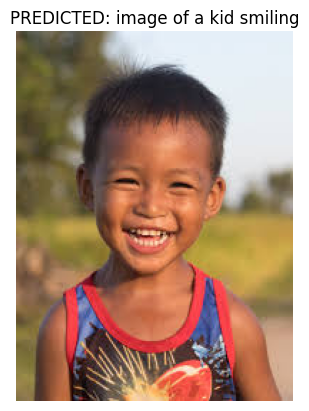

Probabilities:
  a photo of a dog         : 0.00
  an image of a cat        : 0.00
  a photo of an animal     : 0.00
  a photo of a horse       : 0.00
  a photo of a car         : 0.00
  a picture of a dog       : 0.00
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.00
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.00
  a photo of a furry animal: 0.00
  a car from a side view   : 0.00
  an image of a wild animal: 0.00
  an image of a mountain   : 0.00
  image of a kid smiling   : 1.00
  an image of two kids playing: 0.00
  a blue bmw car           : 0.00



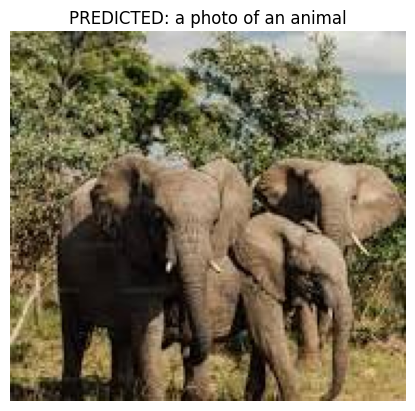

Probabilities:
  a photo of a dog         : 0.00
  an image of a cat        : 0.00
  a photo of an animal     : 0.60
  a photo of a horse       : 0.01
  a photo of a car         : 0.00
  a picture of a dog       : 0.00
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.00
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.00
  a photo of a furry animal: 0.06
  a car from a side view   : 0.00
  an image of a wild animal: 0.24
  an image of a mountain   : 0.00
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.06
  a blue bmw car           : 0.00



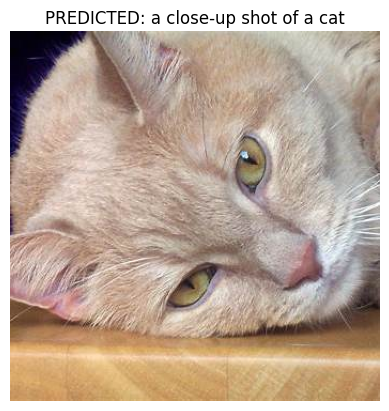

Probabilities:
  a photo of a dog         : 0.00
  an image of a cat        : 0.09
  a photo of an animal     : 0.01
  a photo of a horse       : 0.00
  a photo of a car         : 0.00
  a picture of a dog       : 0.00
  a close-up shot of a cat : 0.40
  a car parked on a street : 0.00
  a domestic cat           : 0.18
  a street dog             : 0.00
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.29
  a car in motion          : 0.00
  a photo of a furry animal: 0.02
  a car from a side view   : 0.00
  an image of a wild animal: 0.00
  an image of a mountain   : 0.00
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.00
  a blue bmw car           : 0.00



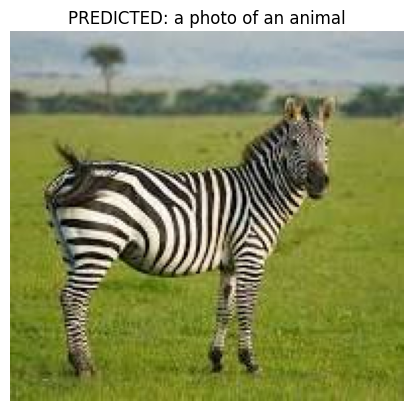

Probabilities:
  a photo of a dog         : 0.00
  an image of a cat        : 0.00
  a photo of an animal     : 0.49
  a photo of a horse       : 0.04
  a photo of a car         : 0.00
  a picture of a dog       : 0.00
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.00
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.00
  a photo of a furry animal: 0.19
  a car from a side view   : 0.00
  an image of a wild animal: 0.26
  an image of a mountain   : 0.00
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.00
  a blue bmw car           : 0.00



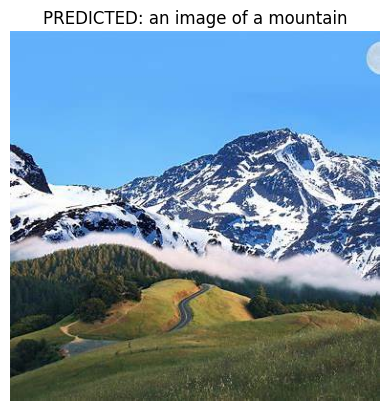

Probabilities:
  a photo of a dog         : 0.00
  an image of a cat        : 0.00
  a photo of an animal     : 0.00
  a photo of a horse       : 0.00
  a photo of a car         : 0.00
  a picture of a dog       : 0.00
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.00
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.00
  a photo of a furry animal: 0.00
  a car from a side view   : 0.00
  an image of a wild animal: 0.00
  an image of a mountain   : 0.99
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.00
  a blue bmw car           : 0.00



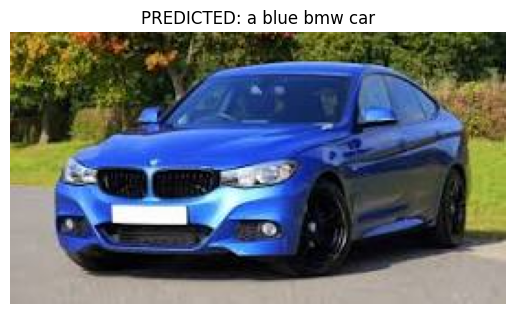

Probabilities:
  a photo of a dog         : 0.00
  an image of a cat        : 0.00
  a photo of an animal     : 0.00
  a photo of a horse       : 0.00
  a photo of a car         : 0.00
  a picture of a dog       : 0.00
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.00
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.00
  a photo of a furry animal: 0.00
  a car from a side view   : 0.00
  an image of a wild animal: 0.00
  an image of a mountain   : 0.00
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.00
  a blue bmw car           : 1.00



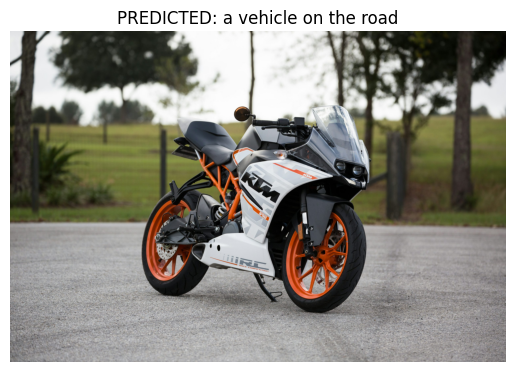

Probabilities:
  a photo of a dog         : 0.01
  an image of a cat        : 0.04
  a photo of an animal     : 0.11
  a photo of a horse       : 0.04
  a photo of a car         : 0.07
  a picture of a dog       : 0.01
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.01
  a domestic cat           : 0.01
  a street dog             : 0.01
  a vehicle on the road    : 0.28
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.17
  a photo of a furry animal: 0.02
  a car from a side view   : 0.14
  an image of a wild animal: 0.06
  an image of a mountain   : 0.01
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.00
  a blue bmw car           : 0.00



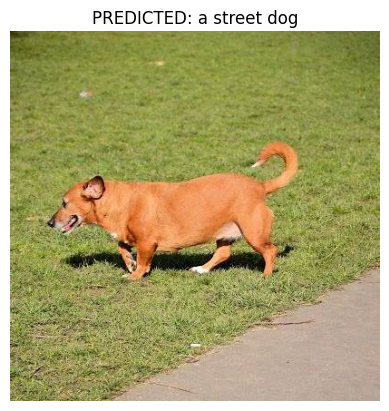

Probabilities:
  a photo of a dog         : 0.24
  an image of a cat        : 0.00
  a photo of an animal     : 0.03
  a photo of a horse       : 0.00
  a photo of a car         : 0.00
  a picture of a dog       : 0.12
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.57
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.00
  a photo of a furry animal: 0.01
  a car from a side view   : 0.00
  an image of a wild animal: 0.02
  an image of a mountain   : 0.00
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.00
  a blue bmw car           : 0.00



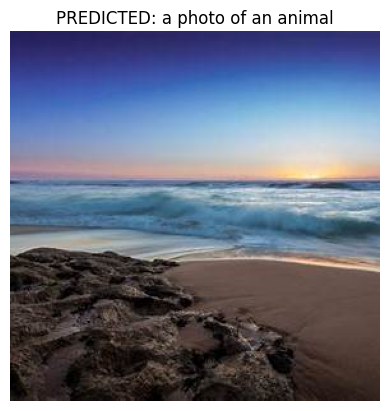

Probabilities:
  a photo of a dog         : 0.07
  an image of a cat        : 0.01
  a photo of an animal     : 0.23
  a photo of a horse       : 0.05
  a photo of a car         : 0.04
  a picture of a dog       : 0.07
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.03
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.01
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.04
  a photo of a furry animal: 0.09
  a car from a side view   : 0.01
  an image of a wild animal: 0.06
  an image of a mountain   : 0.22
  image of a kid smiling   : 0.00
  an image of two kids playing: 0.06
  a blue bmw car           : 0.00



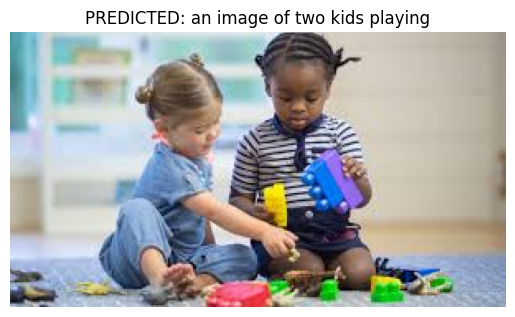

Probabilities:
  a photo of a dog         : 0.00
  an image of a cat        : 0.00
  a photo of an animal     : 0.00
  a photo of a horse       : 0.00
  a photo of a car         : 0.00
  a picture of a dog       : 0.00
  a close-up shot of a cat : 0.00
  a car parked on a street : 0.00
  a domestic cat           : 0.00
  a street dog             : 0.00
  a vehicle on the road    : 0.00
  a horse running in a field: 0.00
  a portrait of a dog      : 0.00
  a zoomed-in image of a cat's face: 0.00
  a car in motion          : 0.00
  a photo of a furry animal: 0.00
  a car from a side view   : 0.00
  an image of a wild animal: 0.00
  an image of a mountain   : 0.00
  image of a kid smiling   : 0.00
  an image of two kids playing: 1.00
  a blue bmw car           : 0.00



In [43]:
# Print predictions
for i, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"PREDICTED: {text_prompts[probs[i].argmax()]}")
    plt.show()
    print("Probabilities:")
    for j, txt in enumerate(text_prompts):
        print(f"  {txt:<25}: {probs[i][j]:.2f}")
    print()

### Task 3.3: Discussion

##### Try varying your text prompts. Does the classification change?

*The classification becomes more accurate when the prompt description is precise to what the image is*

##### What kind of errors does CLIP make? Are they semantically reasonable?

*CLIP can confuse visually or conceptually similar categories e.g a horse <-> zebra, error with dealing with abstract prompts like "an joyful image" or "freedom"*

##### How does this compare to traditional classification models?

*if we want flexibility then CLIP is semantically aware, while traditional classifiers are more precise within a specific domain*